In [17]:
#this script computes flow law parameters for river discharge
# by Mike, October 13, 2021.

# the "using" function pulls in the Julia libraries we need
using Pkg
using JuMP
using Ipopt
using Plots
using Random
using Statistics

In [18]:
# define flow distance and true water surface elevation WSE for a 10 km reach. also generate random error to 
#   create "synthetic" observations to test our algorithm on
dx=200
x=[0:dx:10e3]
x=x[1]
nx=length(x)
wse_true=zeros(size(x))

S1=50e-5  
S2=100e-5 
S3=20e-5 

wse_true[1]=100
for i=2:nx
    if i>25
        S=S3
    elseif i>13
        S=S2
    else 
        S=S1
    end
    wse_true[i]=wse_true[i-1]-S*dx
end

# now generate synthetic observations by adding random error
stdh=0.3 #height error
rng = MersenneTwister(1234);
wse_obs=wse_true+randn(rng, Float32, size(wse_true))*stdh;

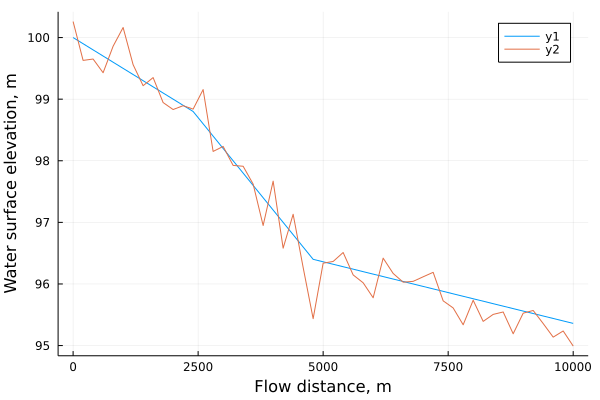

In [19]:
plot(x,[wse_true,wse_obs])
#plot(x,wse_obs)
xlabel!("Flow distance, m")
ylabel!("Water surface elevation, m")

In [20]:
# your task - find a way to make a new estimate of WSE that 1) is as close as possible to the observations
# and 2) always goes downhill. hint! you can use a for loop to create a bunch of constraints at once

# first step - get the optimization to run without any constraints
m = Model(optimizer_with_attributes(Ipopt.Optimizer))
@variable(m,wse[i=1:nx])
@objective(m,Min, sum( (wse-wse_obs).^2 ) ) ;
for i=2:nx
    @constraint(m,wse[i]<=wse[i-1])
end
optimize!(m)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      100
Number of nonzeros in Lagrangian Hessian.............:       51

Total number of variables............................:       51
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       50
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       50

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

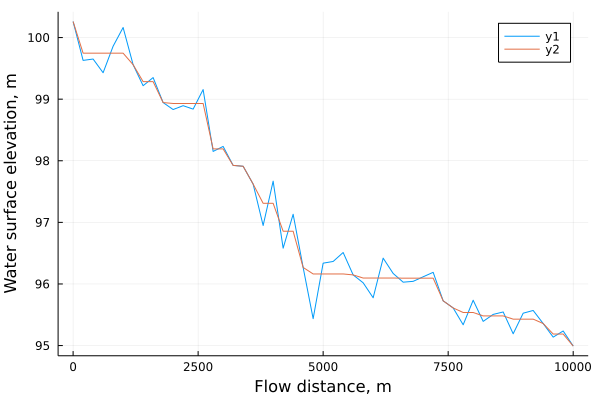

In [21]:
wse_hat=JuMP.value.(wse)
plot(x,[wse_obs,wse_hat])
xlabel!("Flow distance, m")
ylabel!("Water surface elevation, m")

In [22]:
# repeat the exercise to assess improvement in slope accuracy 
#   first look at error if no constraint is applied
nens=10000
S_obs=zeros(nens,1)
for i=1:nens
    wse_obs=wse_true+randn(rng, Float32, size(wse_true))*stdh;
    S_obs[i]=(wse_obs[1]-wse_obs[end])/x[end]    
end

std(S_obs)

4.2011302721011285e-5

In [23]:
nens=1000
S_obsc=zeros(nens,1)
for i=1:nens
    wse_obs=wse_true+randn(rng, Float32, size(wse_true))*stdh;
    
    m = Model(with_optimizer(Ipopt.Optimizer,print_level=0))
    #set_optimizer_attribute(m, "msg_lev" 0)
    @variable(m,wse[i=1:nx])
    @objective(m,Min, sum( (wse-wse_obs).^2 ) ) ;
    for i=2:nx
        @constraint(m,wse[i]<=wse[i-1])
    end
    optimize!(m)
    
    wse_hat=JuMP.value.(wse)    
    
    S_obsc[i]=(wse_hat[1]-wse_hat[end])/x[end]    
    
end



In [24]:
println(std(S_obsc)*1e5)
println(mean(S_obsc)*1e5)
println(median(S_obsc)*1e5)
println((wse_true[1]-wse_true[end])/x[end]*1e5   )

3.0517303119450268
48.49568014206535
48.25915207986597
46.400000000001285


In [32]:
# improvement! error is down from like 4.2 cm/km to 3 cm/km. still not where it could be

# let's try something else. let's minimize magnitude of drops

weight=15

wse_obs=wse_true+randn(rng, Float32, size(wse_true))*stdh; #comment to not regenerate obs

m = Model(with_optimizer(Ipopt.Optimizer,print_level=0))
@variable(m,wse[i=1:nx])
@variable(m,dwse[i=1:nx-1])
@objective(m,Min, sum( (wse-wse_obs).^2 ) + weight*sum( (dwse).^2 ) ) ;
for i=2:nx
    @constraint(m,wse[i]<=wse[i-1])
end
for i=1:nx-1
    @constraint(m,dwse[i]==wse[i+1]-wse[i] )
end
optimize!(m)

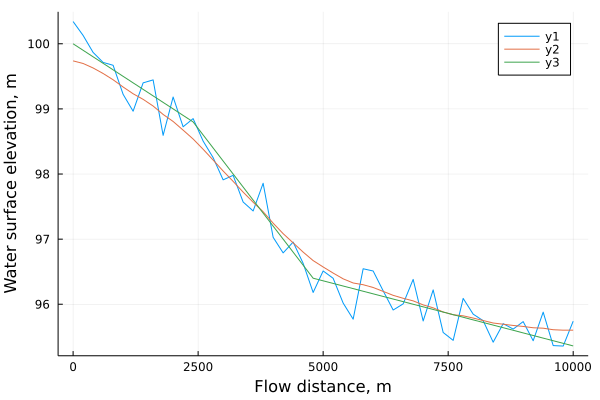

In [33]:
wse_hat=JuMP.value.(wse)
plot(x,[wse_obs,wse_hat,wse_true])
xlabel!("Flow distance, m")
ylabel!("Water surface elevation, m")  

In [27]:
nens=1000
S_obsc=zeros(nens,1)
for i=1:nens
    wse_obs=wse_true+randn(rng, Float32, size(wse_true))*stdh;
    
    m = Model(with_optimizer(Ipopt.Optimizer,print_level=0))
    @variable(m,wse[i=1:nx])
    @variable(m,dwse[i=1:nx-1])
    @objective(m,Min, sum( (wse-wse_obs).^2 ) + weight*sum( (dwse).^2 ) ) ;
    for i=2:nx
        @constraint(m,wse[i]<=wse[i-1])
    end
    for i=1:nx-1
        @constraint(m,dwse[i]==wse[i+1]-wse[i] )
    end
    optimize!(m)
    
    wse_hat=JuMP.value.(wse)    
    
    S_obsc[i]=(wse_hat[1]-wse_hat[end])/x[end]    
    
end

1.4465511801042488e-5

In [28]:
println(std(S_obsc)*1e5)
println(mean(S_obsc)*1e5)
println(median(S_obsc)*1e5)
println((wse_true[1]-wse_true[end])/x[end]*1e5   )

1.4465511801042488
41.54199288215638
41.60715609881876
46.400000000001285


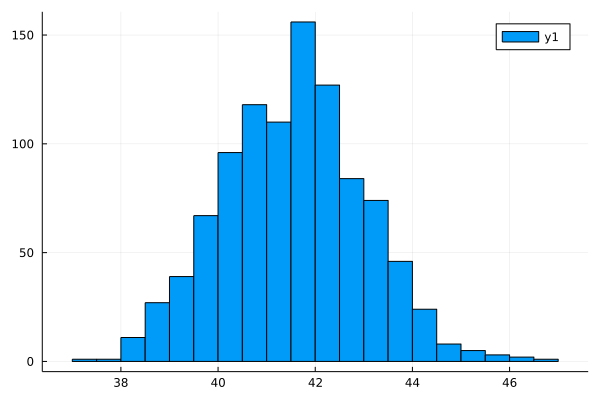

In [35]:
histogram(S_obsc*1e5)